**XGBoost**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import plotly.graph_objs as go
import plotly.offline as py
from IPython.display import display

import re
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
%matplotlib inline

Load Titanic set

In [2]:
train_df  = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
test_df  = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [3]:
train_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Preprocess

In [4]:
#embarked_encoder = LabelEncoder()
#embarked_encoder.fit(train_df['embark_town'].fillna('Null'))

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [6]:
# Dataframes to work on
df_list = [train_df, test_df]

for df in df_list:    
    
    # Record anyone travelling alone
    df['alone'] = (df['n_siblings_spouses'] == 0) & (df['parch'] == 0)
    
    # Transform 'Embarked'
    df['embark_town'].fillna('Null', inplace=True)
    #df['alone'] = embarked_encoder.transform(df['alone'])
    
    # Transform 'Sex'
    df.loc[df['sex'] == 'female','sex'] = 0#
    df.loc[df['sex'] == 'male','sex'] = 1
    df['sex'] = df['sex'].astype('int8') 

    num_of_columns = df.shape[1]
 
    for i in range(0, num_of_columns):
      column_name = df.columns[i]
      column_type = df[column_name].dtypes
            
      if column_type == 'object':
        le.fit(df[column_name])
        feature_classes = list(le.classes_)
        encoded_feature = le.transform(df[column_name])
        df[column_name] = pd.DataFrame(encoded_feature)
 

In [7]:
train_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,1,22.0,1,0,7.2500,2,7,2,False
1,1,0,38.0,1,0,71.2833,0,2,0,False
2,1,0,26.0,0,0,7.9250,2,7,2,True
3,1,0,35.0,1,0,53.1000,0,2,2,False
4,0,1,28.0,0,0,8.4583,2,7,1,True


In [8]:
y = train_df.pop('survived')

# Create a hold out randomly
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)



Using SGBoost DMatrix

In [9]:
# convert to DMatrix
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

Define parameters

In [10]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.1,
    'sample_type': 'uniform',
    'normalize_type': 'tree',
    'objective': 'binary:hinge',
    'rate_drop': 0.1,
    'n_estimators': 500
}

In [11]:
xgb_clf = xgb.train(params_1, d_train)

Make prediction

In [12]:
# make prediction
preds = xgb_clf.predict(d_test)
# print accuracy score
print(np.round(accuracy_score(y_test, preds)*100, 2), '%')

81.75 %


Cross validation Training 

In [13]:
# DMatrix for k-fold cv
dmatrix_data = xgb.DMatrix(X_train, y_train)

In [14]:
params = {
    'objective': 'binary:hinge',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
}
cross_val = xgb.cv(
    params=params,
    dtrain=dmatrix_data, 
    nfold=5,
    num_boost_round=50, 
    early_stopping_rounds=10, 
    metrics='error', 
    as_pandas=True, 
    seed=42)
print(cross_val.head())

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.604784         0.013526         0.604693        0.054126
1          0.604784         0.013526         0.604693        0.054126
2          0.604784         0.013526         0.604693        0.054126
3          0.604784         0.013526         0.604693        0.054126
4          0.604784         0.013526         0.604693        0.054126


Feature importance

<Figure size 1152x864 with 0 Axes>

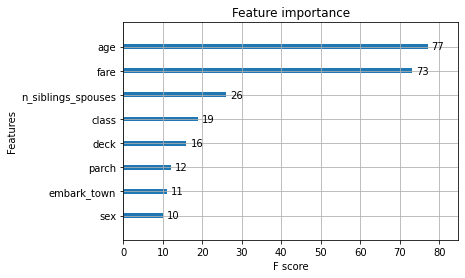

In [15]:
plt.figure(figsize=(16, 12))
xgb.plot_importance(xgb_clf)
plt.show()

Hyperparameter tuning

In [16]:

params = {
        'n_estimators': [100, 200, 500, 1000, 1500],
        'learning_rate': [0.05, 0.1, 0.2]
        #'max_depth':[3, 4, 5]
        }


In [17]:
random_state=42
n_iter = 500 

lgbm_clf = XGBClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=params, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 15 is smaller than n_iter=500. Running 15 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best score reached: 0.8164752475247525 with params: {'n_estimators': 100, 'learning_rate': 0.05} 


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   12.8s finished
